<a href="https://www.kaggle.com/code/a113ssa/implementing-a-cnn-in-tensorflow-and-keras?scriptVersionId=202366209" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import random
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from dataclasses import dataclass

In [3]:
SEED_VALUE = 37

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
X_train shape: (50000, 32, 32, 3), X_test shape: (10000, 32, 32, 3)


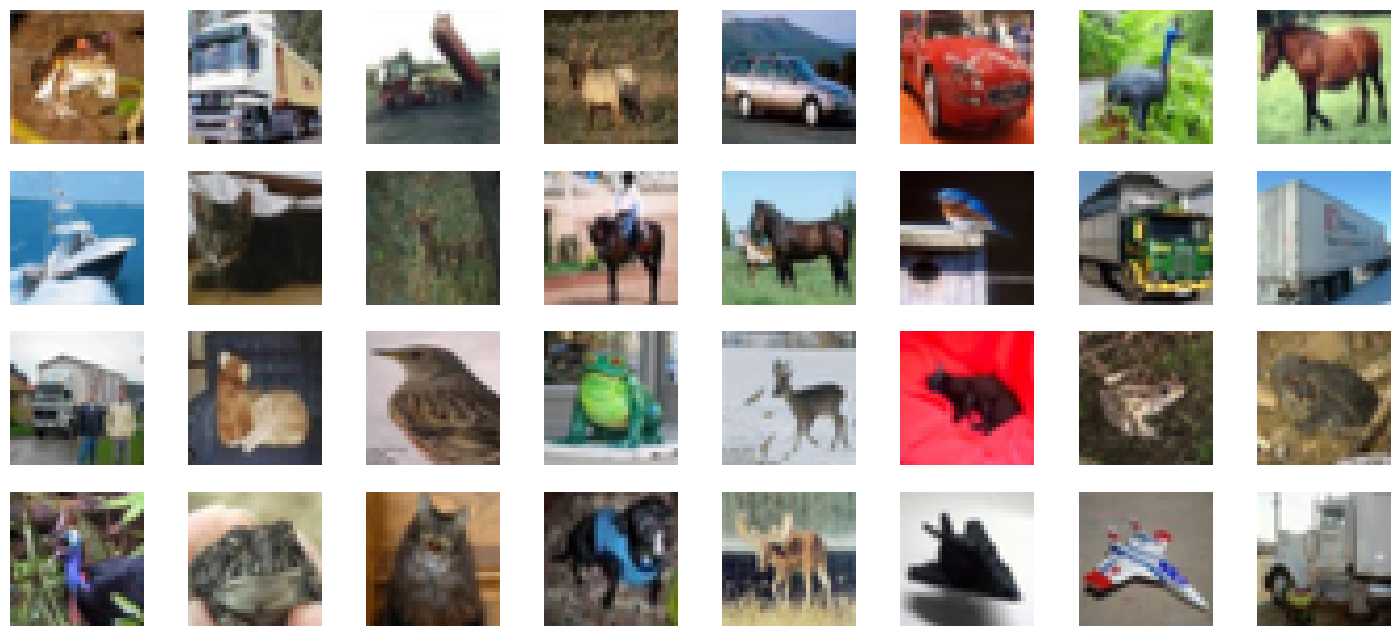

In [5]:
plt.figure(figsize=(18, 8))

num_rows = 4
num_cols = 8

# plot images
for i in range(num_rows * num_cols):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(X_train[i, :, :])
    plt.axis('off')

In [6]:
def normalize(data):
    return data.astype('float32') / 255

In [7]:
X_train = normalize(X_train)
X_test = normalize(X_test)

print(f'Original (integer) label for the first training sample: {y_train[0]}')
      
# use one-hot encodeing
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'After conversion to one-hot encoded labels: {y_train[0]}')

Original (integer) label for the first training sample: [6]
After conversion to one-hot encoded labels: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [8]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 10
    IMG_HEIGHT: int = 32
    IMG_WIDTH: int = 32
    NUM_CHANNELS: int = 3
        
@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS: int  = 31
    BATCH_SIZE: int = 256
    LEARNING_RATE: float = 0.001

In [9]:
def add_conv2d_layers(model, layers_amount=1, filters_amount=16):
    for i in range(layers_amount):
        model.add(Conv2D(filters=filters_amount, kernel_size=3, padding='same', activation='relu'))

def cnn_model(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    pool_size = (2,2)
    
    # conv block 1: 32 filters, maxpooling
    add_conv2d_layers(model, layers_amount=2, filters_amount=32)
    model.add(MaxPooling2D(pool_size=pool_size))
    
    # conv block 2: 64 filters, maxpooling
    add_conv2d_layers(model, layers_amount=2, filters_amount=64)
    model.add(MaxPooling2D(pool_size=pool_size))
    
    # conv block 3: 64 filters, maxpooling
    add_conv2d_layers(model, layers_amount=2, filters_amount=64)
    model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    return model

In [10]:
model = cnn_model()

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 669,354 (2.55 MB)

 Trainable params: 669,354 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
history = model.fit(
    X_train,
    y_train,
    batch_size=TrainingConfig.BATCH_SIZE,
    epochs=TrainingConfig.EPOCHS,
    verbose=1,
    validation_split=0.3
)

Epoch 1/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 110s 792ms/step - accuracy: 0.1729 - loss: 2.2084 - val_accuracy: 0.2729 - val_loss: 1.9787
Epoch 2/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 109s 794ms/step - accuracy: 0.3483 - loss: 1.7894 - val_accuracy: 0.4411 - val_loss: 1.5207
Epoch 3/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 109s 797ms/step - accuracy: 0.4430 - loss: 1.5248 - val_accuracy: 0.5093 - val_loss: 1.3444
Epoch 4/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 108s 791ms/step - accuracy: 0.5089 - loss: 1.3604 - val_accuracy: 0.5239 - val_loss: 1.3354
Epoch 5/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 142s 795ms/step - accuracy: 0.5673 - loss: 1.2071 - val_accuracy: 0.5892 - val_loss: 1.1692
Epoch 6/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 141s 790ms/step - accuracy: 0.6169 - loss: 1.0753 - val_accuracy: 0.5943 - val_loss: 1.2071
Epoch 7/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 143s 800ms/step - accuracy: 0.6580 - loss: 0.9685 - val_accuracy: 0.6407 - val_loss: 1.0881
Epoch 8/31
137/137 ━━━━━━━━━━━━━━━━━━━━ 109s 796ms/step - accuracy: 0.7013 -

In [13]:
# to be continued